In [91]:
import pandas as pd
import numpy as np
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import seaborn as sns
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings  
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [92]:
data = pd.read_excel("output.xlsx")

In [93]:
data.head()

,Created On,Order Item,Quantity,Order Item
0,2019-01-10 10:27:07,sedona salad,1,sedona salad
1,2019-01-10 16:48:23,Canned Soda,1,canned soda
2,2019-01-10 16:52:28,Canned Soda,1,canned soda
3,2019-01-10 17:00:10,2 Liter Soda,1,2 liter soda
4,2019-01-10 17:20:27,Cheese Pizza,1,cheese pizza


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1697 entries, 0 to 1696
Data columns (total 4 columns):
Created On     1697 non-null datetime64[ns]
Order Item     1697 non-null object
 Quantity      1697 non-null int64
Order Item     1697 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 66.3+ KB


In [95]:
data.drop(columns=['Order Item ', 'Order Item'],inplace=True)

In [96]:
data = data.set_index('Created On')

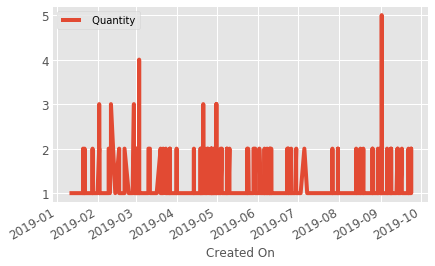

In [97]:
data.plot()

In [98]:
weekly = data.resample('W').sum()
weekly.head()
#weekly.plot(style=[':', '--','-'])

,Quantity
Created On,
2019-01-13,12
2019-01-20,27
2019-01-27,39
2019-02-03,38
2019-02-10,19


In [99]:
daily=data.resample('D').sum()
#daily.rolling(30,center=True).sum().plot(style=[':' ,'--','-'])
daily.head()

,Quantity
Created On,
2019-01-10,5
2019-01-11,2
2019-01-12,0
2019-01-13,5
2019-01-14,0


In [101]:
by_time=data.groupby(data.index.time).mean()
hourly_ticks= 4 * 60 * np.arange(6)
#by_time.plot(xticks=hourly_ticks, style=[':' ,'--','-'])
by_time.head()

,Quantity
10:27:07,1.0
11:03:15,1.0
11:05:58,2.0
11:06:09,1.0
11:11:21,1.0


In [102]:
hourly=data.resample('H').sum()
#hourly.plot(style=[':', '--','-'])
hourly.head()

,Quantity
Created On,
2019-01-10 10:00:00,1
2019-01-10 11:00:00,0
2019-01-10 12:00:00,0
2019-01-10 13:00:00,0
2019-01-10 14:00:00,0


In [104]:
hourly.tail()
#print(hourly.columns)

,Quantity
Created On,
2019-09-23 14:00:00,0
2019-09-23 15:00:00,0
2019-09-23 16:00:00,0
2019-09-23 17:00:00,0
2019-09-23 18:00:00,5


In [105]:
df2 = hourly
hourly.reset_index(inplace=True)
df2 = df2.rename(columns={'Created On':'ds',' Quantity':'y'})
df2.head()

,ds,y
0,2019-01-10 10:00:00,1
1,2019-01-10 11:00:00,0
2,2019-01-10 12:00:00,0
3,2019-01-10 13:00:00,0
4,2019-01-10 14:00:00,0


In [106]:
import fbprophet

In [35]:
# https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8

In [107]:
df2_prophet = fbprophet.Prophet(changepoint_prior_scale=0.10)
df2_prophet.fit(df2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [108]:
df2_forecast = df2_prophet.make_future_dataframe(periods=30*2, freq='D')
df2_forecast = df2_prophet.predict(df2_forecast)

Text(0.5, 1.0, 'Simple forecast')

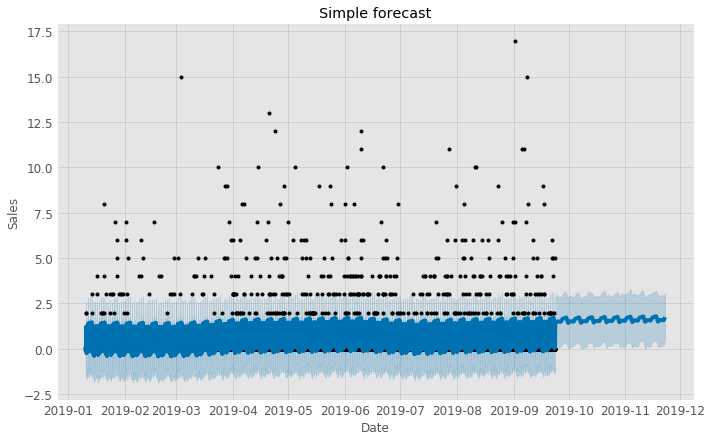

In [109]:
df2_prophet.plot(df2_forecast, xlabel= 'Date',ylabel='Sales')
plt.title('Daily forecast')

In [111]:
df2_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-10 10:00:00,0.159215,-1.575953,1.255023,0.159215,0.159215,-0.311374,-0.311374,-0.311374,-0.186491,-0.186491,-0.186491,-0.124883,-0.124883,-0.124883,0.0,0.0,0.0,-0.152159
1,2019-01-10 11:00:00,0.159199,-1.288337,1.489677,0.159199,0.159199,-0.124246,-0.124246,-0.124246,-0.001892,-0.001892,-0.001892,-0.122354,-0.122354,-0.122354,0.0,0.0,0.0,0.034953
2,2019-01-10 12:00:00,0.159183,-1.310547,1.402565,0.159183,0.159183,-0.059829,-0.059829,-0.059829,0.059137,0.059137,0.059137,-0.118966,-0.118966,-0.118966,0.0,0.0,0.0,0.099353
3,2019-01-10 13:00:00,0.159167,-1.396161,1.369378,0.159167,0.159167,-0.149680,-0.149680,-0.149680,-0.034934,-0.034934,-0.034934,-0.114747,-0.114747,-0.114747,0.0,0.0,0.0,0.009486
4,2019-01-10 14:00:00,0.159151,-1.463478,1.241799,0.159151,0.159151,-0.238960,-0.238960,-0.238960,-0.129226,-0.129226,-0.129226,-0.109734,-0.109734,-0.109734,0.0,0.0,0.0,-0.079809


In [112]:
df2_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
6208,2019-11-18 18:00:00,0.492542,0.116787,3.003149,0.303021,0.681496,1.003599,1.003599,1.003599,1.155463,1.155463,1.155463,-0.151865,-0.151865,-0.151865,0.0,0.0,0.0,1.496141
6209,2019-11-19 18:00:00,0.494037,0.106955,2.911640,0.298397,0.689265,1.096051,1.096051,1.096051,1.155463,1.155463,1.155463,-0.059412,-0.059412,-0.059412,0.0,0.0,0.0,1.590088
6210,2019-11-20 18:00:00,0.495531,0.191540,2.990672,0.294298,0.696883,1.092548,1.092548,1.092548,1.155463,1.155463,1.155463,-0.062915,-0.062915,-0.062915,0.0,0.0,0.0,1.588079
6211,2019-11-21 18:00:00,0.497026,0.160245,2.935547,0.288840,0.704165,1.072685,1.072685,1.072685,1.155463,1.155463,1.155463,-0.082778,-0.082778,-0.082778,0.0,0.0,0.0,1.569711
6212,2019-11-22 18:00:00,0.498520,0.451778,3.072578,0.286166,0.710302,1.240416,1.240416,1.240416,1.155463,1.155463,1.155463,0.084953,0.084953,0.084953,0.0,0.0,0.0,1.738937


Text(0.5, 1.0, 'Hourly forecast')

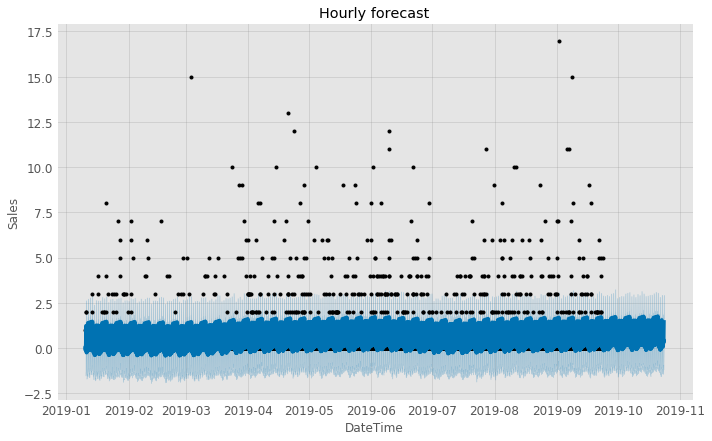

In [113]:
df2_forecast_hourly = df2_prophet.make_future_dataframe(periods=30*24, freq='H')
df2_forecast_hourly = df2_prophet.predict(df2_forecast_hourly)
df2_prophet.plot(df2_forecast_hourly, xlabel= 'DateTime',ylabel='Sales')
plt.title('Hourly forecast')

In [114]:
df2_forecast_hourly.tail(10)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
6863,2019-10-23 09:00:00,0.453125,-1.369994,1.483430,0.377591,0.520722,-0.351825,-0.351825,-0.351825,-0.341562,-0.341562,-0.341562,-0.010263,-0.010263,-0.010263,0.0,0.0,0.0,0.101300
6864,2019-10-23 10:00:00,0.453187,-1.071967,1.629854,0.377480,0.520876,-0.200389,-0.200389,-0.200389,-0.186491,-0.186491,-0.186491,-0.013897,-0.013897,-0.013897,0.0,0.0,0.0,0.252798
6865,2019-10-23 11:00:00,0.453249,-1.002451,1.858646,0.377369,0.521031,-0.020161,-0.020161,-0.020161,-0.001892,-0.001892,-0.001892,-0.018269,-0.018269,-0.018269,0.0,0.0,0.0,0.433089
6866,2019-10-23 12:00:00,0.453311,-0.983804,1.871871,0.377258,0.521185,0.035828,0.035828,0.035828,0.059137,0.059137,0.059137,-0.023309,-0.023309,-0.023309,0.0,0.0,0.0,0.489140
6867,2019-10-23 13:00:00,0.453374,-0.910976,1.780128,0.377147,0.521339,-0.063875,-0.063875,-0.063875,-0.034934,-0.034934,-0.034934,-0.028941,-0.028941,-0.028941,0.0,0.0,0.0,0.389499
6868,2019-10-23 14:00:00,0.453436,-1.187212,1.606083,0.377036,0.521494,-0.164310,-0.164310,-0.164310,-0.129226,-0.129226,-0.129226,-0.035084,-0.035084,-0.035084,0.0,0.0,0.0,0.289126
6869,2019-10-23 15:00:00,0.453498,-0.965342,1.815288,0.376925,0.521660,-0.049131,-0.049131,-0.049131,-0.007483,-0.007483,-0.007483,-0.041647,-0.041647,-0.041647,0.0,0.0,0.0,0.404368
6870,2019-10-23 16:00:00,0.453561,-0.590090,2.172505,0.376814,0.521839,0.345758,0.345758,0.345758,0.394296,0.394296,0.394296,-0.048539,-0.048539,-0.048539,0.0,0.0,0.0,0.799318
6871,2019-10-23 17:00:00,0.453623,-0.182486,2.758614,0.376703,0.522019,0.832125,0.832125,0.832125,0.887786,0.887786,0.887786,-0.055661,-0.055661,-0.055661,0.0,0.0,0.0,1.285748
6872,2019-10-23 18:00:00,0.453685,0.251953,2.945593,0.376598,0.522226,1.092548,1.092548,1.092548,1.155463,1.155463,1.155463,-0.062915,-0.062915,-0.062915,0.0,0.0,0.0,1.546233


In [116]:
df2_forecast_hourly[df2_forecast_hourly['ds']=='2019-10-23 18:00:00']

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
6872,2019-10-23 18:00:00,0.453685,0.251953,2.945593,0.376598,0.522226,1.092548,1.092548,1.092548,1.155463,1.155463,1.155463,-0.062915,-0.062915,-0.062915,0.0,0.0,0.0,1.546233


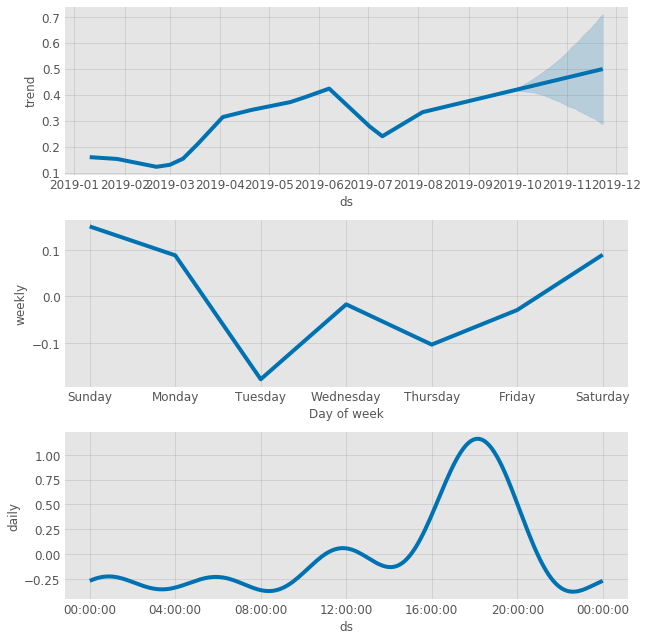

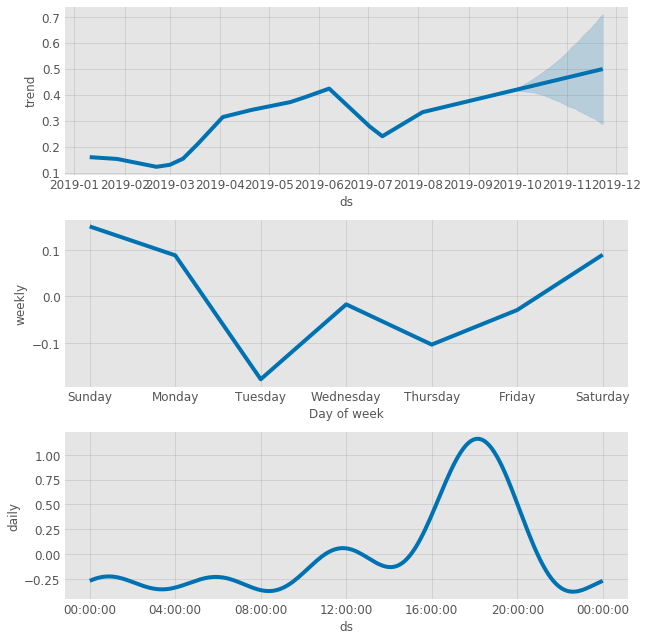

In [115]:
df2_prophet.plot_components(df2_forecast)

In [75]:
#LSTM
hourly=data.resample('H').sum()

In [76]:
hourly = hourly.rename(columns={'Created On':'date'})

In [77]:
hourly.head()

,Quantity
Created On,
2019-01-10 10:00:00,1
2019-01-10 11:00:00,0
2019-01-10 12:00:00,0
2019-01-10 13:00:00,0
2019-01-10 14:00:00,0


In [78]:
mydata = hourly.loc[:,[' Quantity']]
mydata.head()

,Quantity
Created On,
2019-01-10 10:00:00,1
2019-01-10 11:00:00,0
2019-01-10 12:00:00,0
2019-01-10 13:00:00,0
2019-01-10 14:00:00,0


In [81]:
from sklearn.preprocessing import MinMaxScaler
values = mydata[' Quantity'].values.reshape(-1,1)
values = values.astype('float32')
scaler=MinMaxScaler(feature_range=(0,1))
scaled=scaler.fit_transform(values)

In [83]:
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test  = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train),len(test))

4922 1231


In [84]:
def create_dataset(dataset, look_back=1):
    dataX , dataY =[] , []
    for i in range(len(dataset) - look_back):
        a = dataset[i: (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX) , np.array(dataY)

In [85]:
look_back=2
trainX, trainY  = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

4920
1229


In [88]:
trainX = np.reshape(trainX, (trainX.shape[0], 2 , trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 2 , testX.shape[1]))

ValueError: cannot reshape array of size 9840 into shape (4920,2,2)

In [89]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='max', optimizer='adam')
history=model.fit(trainX, trainY, epoch=100, batch_size=100,validation_data=(testX,testY),verbose=0,shuffle=False)

ModuleNotFoundError: No module named 'keras'

In [90]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()

NameError: name 'history' is not defined